# 002.03 EDA - Shots 

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import scipy.stats as stats

from typing import List, Tuple, Union, Callable
from types import ModuleType

from statsmodels.graphics.mosaicplot import mosaic
# import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import vstacked_bar_charts, diagnose_discrete_fit
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

DATA_DIR = PROJECT_DIR / 'data'
SCOPED_DATA_DIR = DATA_DIR / '03-scoped'

## Three Seasons of English Premier League

In [2]:
league = 'english-premier-league'
load_fp = SCOPED_DATA_DIR / league / str(league + '-scoped-1.csv')
seasons = ['2009-2010', '2010-2011', '2011-2012']

In [3]:
df = pd.read_csv(load_fp, parse_dates = ['date'], index_col=None)
df = df[df['season'].isin(seasons)]
# Calculate Results column
conditions = [df['h_ftgoals'] > df['a_ftgoals'],
              df['h_ftgoals'] == df['a_ftgoals'],
              df['h_ftgoals'] < df['a_ftgoals']]
choices = ['hwin', 'draw', 'awin']
df['result'] = np.select(conditions, choices, default='not-played')
df.head()

,season,date,h,a,h_ftgoals,a_ftgoals,h_htgoals,a_htgoals,h_corners,h_fouls,h_ycards,h_rcards,h_shots,h_sot,a_corners,a_fouls,a_ycards,a_rcards,a_shots,a_sot,odds_hwin_bbmean,odds_draw_bbmean,odds_awin_bbmean,odds_hwin_bbmax,odds_draw_bbmax,odds_awin_bbmax,odds_hwin_WH,odds_draw_WH,odds_awin_WH,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,heatmap_path,shotmap_path,result
0,2009-2010,2009-08-15,aston-villa,wigan-athletic,0.0,2.0,0.0,1.0,4.0,15.0,2.0,0.0,11.0,5.0,6.0,14.0,2.0,0.0,14.0,7.0,1.66,3.51,5.33,1.72,3.77,6.05,1.70,3.4,5.50,1.91,2.04,1.81,1.92,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
1,2009-2010,2009-08-15,blackburn-rovers,manchester-city,0.0,2.0,0.0,1.0,5.0,12.0,2.0,0.0,17.0,9.0,4.0,9.0,1.0,0.0,8.0,5.0,3.37,3.24,2.12,3.78,3.35,2.25,3.50,3.2,2.15,1.78,2.15,1.71,2.04,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
2,2009-2010,2009-08-15,bolton-wanderers,sunderland,0.0,1.0,0.0,1.0,4.0,16.0,2.0,0.0,11.0,3.0,7.0,10.0,1.0,0.0,20.0,13.0,2.24,3.20,3.15,2.37,3.31,3.40,2.30,3.2,3.20,1.70,2.25,1.66,2.12,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin
3,2009-2010,2009-08-15,chelsea,hull-city,2.0,1.0,1.0,1.0,12.0,13.0,1.0,0.0,26.0,12.0,4.0,15.0,2.0,0.0,7.0,3.0,1.17,6.26,16.39,1.20,7.71,23.14,1.17,6.5,21.00,2.44,1.67,2.26,1.58,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,hwin
4,2009-2010,2009-08-15,everton,arsenal,1.0,6.0,0.0,3.0,4.0,11.0,0.0,0.0,8.0,5.0,9.0,13.0,0.0,0.0,15.0,9.0,3.07,3.21,2.28,3.34,3.34,2.42,3.20,3.2,2.30,1.77,2.20,1.70,2.06,/data/02-interim/football-data/english-premier...,/data/02-interim/football-data/english-premier...,awin


## Shots

In [4]:
h_shots = df['h_shots'].dropna().astype('int')
a_shots = df['a_shots'].dropna().astype('int')

h_shots_mean = df['h_shots'].mean()
a_shots_mean = df['a_shots'].mean()

h_shots_var = df['h_shots'].var()
a_shots_var = df['a_shots'].var()

print(f'Home Shots:\nMean:\t\t{h_shots_mean}\nVariance:\t{h_shots_var}')
print(f'Away Shots:\nMean:\t\t{a_shots_mean}\nVariance:\t{a_shots_var}')

Home Shots:
Mean:		14.021929824561404
Variance:	26.511371162762092
Away Shots:
Mean:		11.071929824561403
Variance:	20.465409793139514


In [5]:
# Need to deal with any shot value that has no occurrences in any game
# eg 2 games have 5 shots | 0 games have 6 shots | 1 game has 7 shots
# !! Important to do this every freq count
max_shots = df[['h_shots', 'a_shots']].max().max().astype('int')
h_shots_val_counts = h_shots.value_counts()
h_shots_dist = h_shots.value_counts().sort_index(). \
                    reindex(range(max_shots+1), fill_value=0)
a_shots_val_counts = a_shots.value_counts()
a_shots_dist = a_shots.value_counts().sort_index(). \
                    reindex(range(max_shots+1), fill_value=0)    

shots_dists = pd.concat([h_shots_dist, a_shots_dist], axis=1)

print(f'Home and Away Shots Distributions:\n\n{shots_dists}\n')

Home and Away Shots Distributions:

    h_shots  a_shots
0         0        1
1         1        0
2         3        9
3         5       27
4        10       30
5        11       44
6        27       52
7        45       96
8        51       82
9        58      109
10       84      106
11       85       90
12       97      107
13       98       91
14       85       62
15       73       41
16       76       42
17       68       47
18       53       28
19       40       25
20       43       19
21       28       12
22       15        4
23       25        5
24       18        4
25       15        3
26       11        2
27        6        2
28        5        0
29        1        0
30        0        0
31        0        0
32        1        0
33        1        0
34        0        0
35        1        0



In [6]:
shots_dists_freqs = shots_dists.copy(deep=True)
shots_dists_freqs['h_shots'] = shots_dists_freqs['h_shots'] / shots_dists['h_shots'].sum()
shots_dists_freqs['a_shots'] = shots_dists_freqs['a_shots'] / shots_dists['a_shots'].sum()
shots_dists_freqs.head()


,h_shots,a_shots
0,0.000000,0.000877
1,0.000877,0.000000
2,0.002632,0.007895
3,0.004386,0.023684
4,0.008772,0.026316


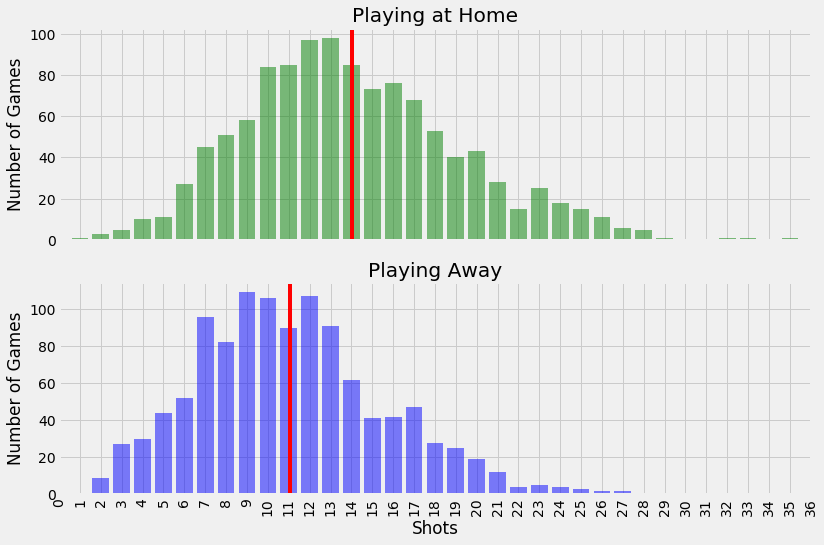

In [7]:
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,figsize=(12,8), sharex=True)


ax1.bar(shots_dists.index, shots_dists['h_shots'], color='g', alpha=0.5, label='Home Shots')
ax1.axvline(h_shots_mean, color='r')
ax1.set_title('Playing at Home')
ax1.set_ylabel('Number of Games')

ax2.bar(shots_dists.index, shots_dists['a_shots'], color='b', alpha=0.5, label='Away Shots')
ax2.axvline(a_shots_mean, color='r')
ax2.set_title('Playing Away')
ax2.set_ylabel('Number of Games')
ax2.set_xlabel('Shots')
ax2.set_xlim(0, len(shots_dists))

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=90)

plt.show();

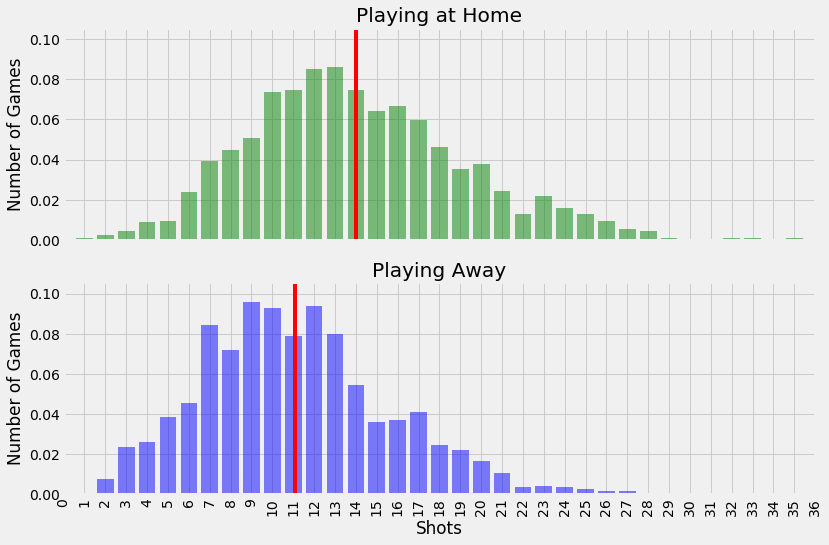

In [8]:
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,figsize=(12,8), sharex=True)


ax1.bar(shots_dists.index, shots_dists_freqs['h_shots'], color='g', alpha=0.5, label='Home Shots')
ax1.axvline(h_shots_mean, color='r')
ax1.set_title('Playing at Home')
ax1.set_ylabel('Number of Games')
max_ylim = shots_dists_freqs.max(axis=0).max()+0.01
ax1.set_ylim(0, max_ylim)

ax2.bar(shots_dists.index, shots_dists_freqs['a_shots'], color='b', alpha=0.5, label='Away Shots')
ax2.axvline(a_shots_mean, color='r')
ax2.set_title('Playing Away')
ax2.set_ylabel('Number of Games')
ax2.set_xlabel('Shots')
ax2.set_xlim(0, len(shots_dists))
ax2.set_ylim(0, max_ylim)

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=90)

plt.show();

## Fitting Shots Distributions

Thoughts?

The distributions seem to have different locations with Home Field Advantage showing up.

I wonder what this means. Are away teams attacking less, or home teams doing a better job of defending, or a bit of both?

Both distributions seem to have a long right tail. Why is this? Is this particular teams consistently showing in this tail? Why would there be a spike at 23 shots. Is this a natural variation or some artefact of data collection?

Neither distribution seems to be truncated by the natural limit of 0 on the left.

These distributions look pretty spiky.

Maybe there are a lot of distributions with different locations - possibly for each team 

Are there certain teams that have consistently high shots? - Try a Boxplot by Team

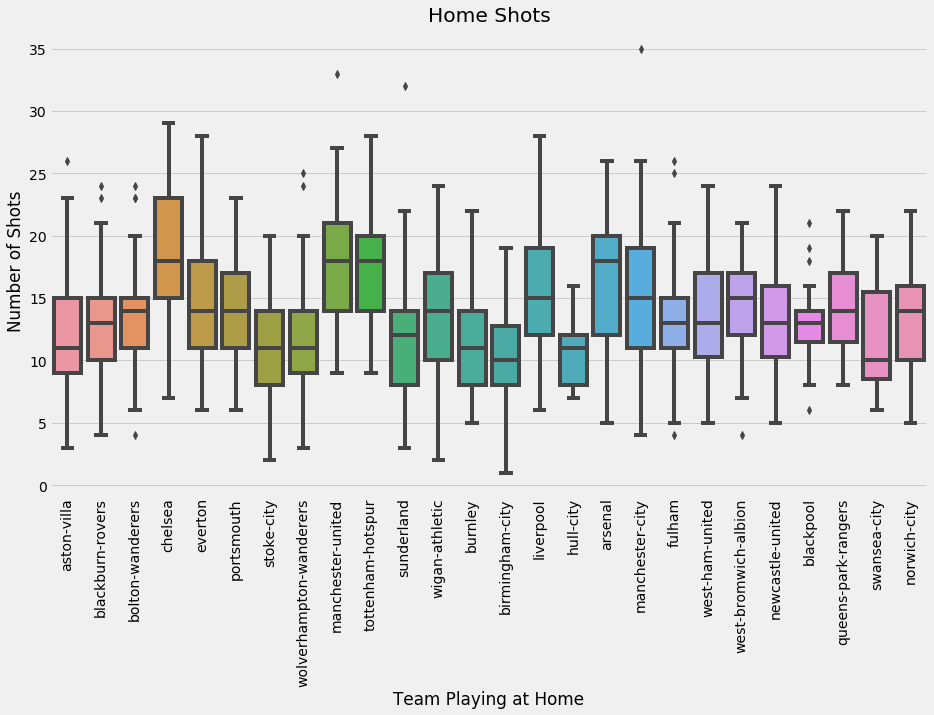

In [9]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

sns.boxplot(x=df["h"], y=df["h_shots"], data=df, ax=ax1)

ax1.set_title('Home Shots')
ax1.set_ylabel('Number of Shots')
ax1.set_xlabel("Team Playing at Home")
plt.xticks(rotation=90)

plt.show();

There is a lot of variation between teams with Tottenham, Liverpool, Reading, and Stoke showing the extremes.

Liverpool seem to have, on average, twice as many shots as Reading and Stoke

Try looking at individual teams distributions

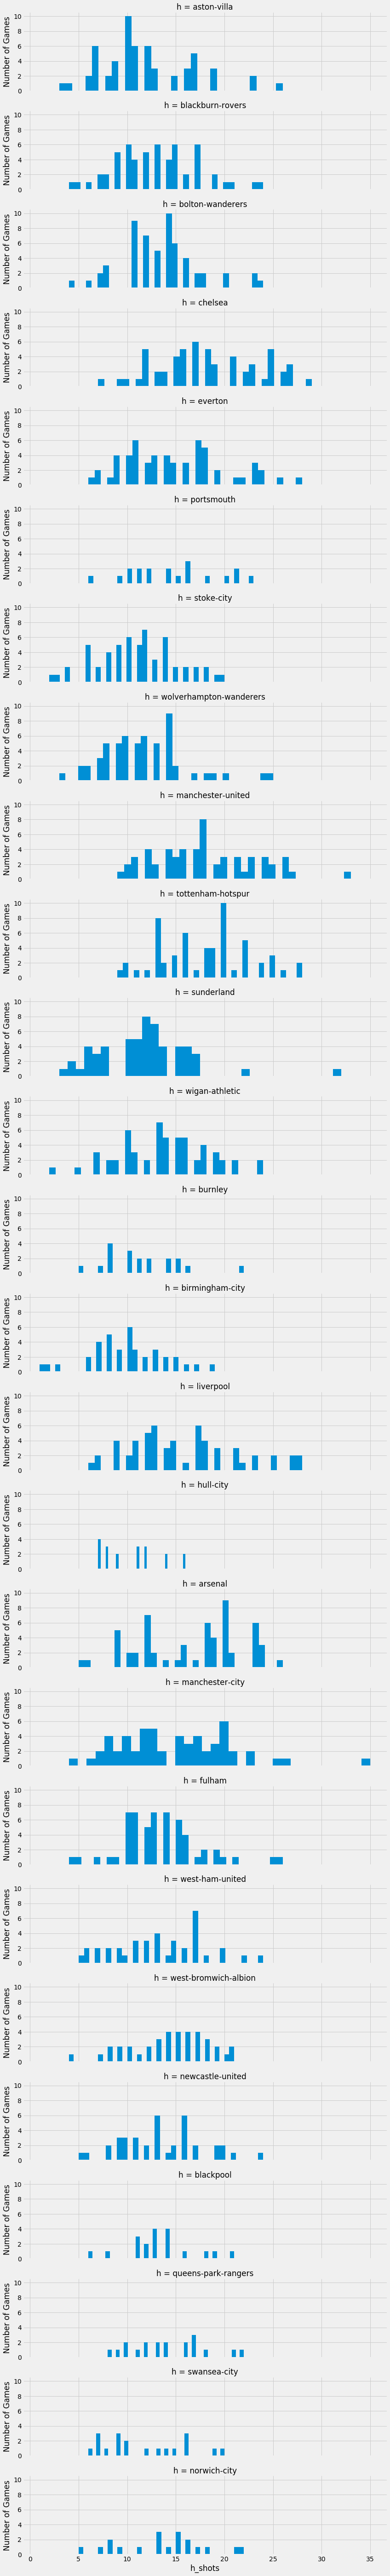

In [10]:
# Reset matplotlib style
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(inline_rc)

bins=34
g = sns.FacetGrid(df, row="h", aspect=4.0 , sharex=True)
g.map(plt.hist, "h_shots", bins=bins);
for ind, _ in enumerate(g.axes):
    g.axes[ind,0].set_ylabel('Number of Games')
plt.tight_layout()
plt.show();

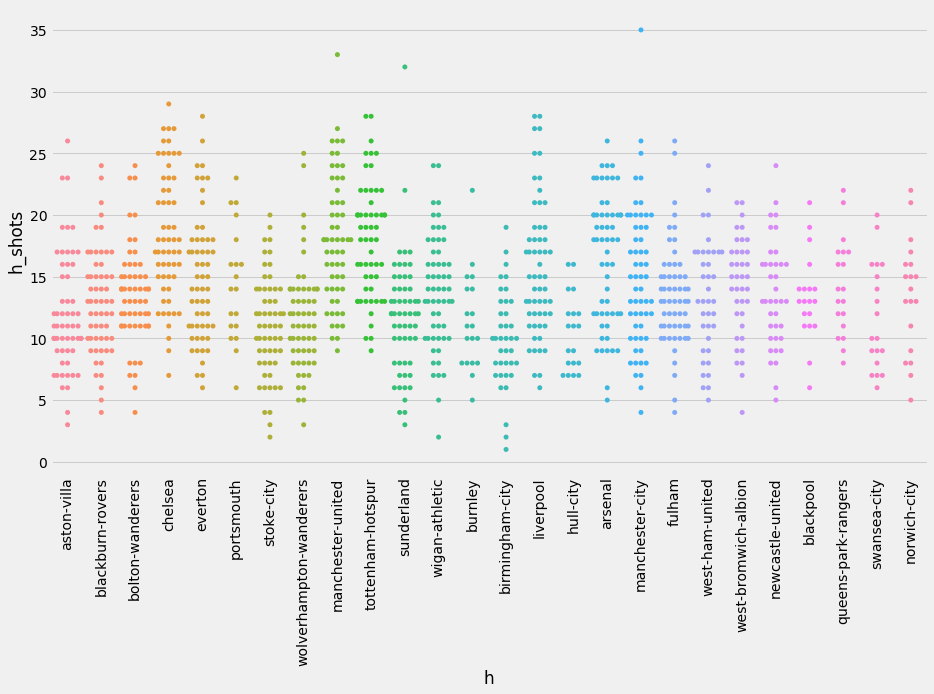

In [11]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

sns.swarmplot(x=df["h"], y=df["h_shots"], data=df, ax=ax1)

# ax1.set_title('Shots')
# ax1.set_ylabel('Number of Shots')
# ax1.set_xlabel("Team Playing at Home")
# plt.xticks(rotation=90)


# # Draw a nested boxplot to show bills by day and time
# sns.boxplot(x=df['h'], y=df['h_shots'],
#             hue=df['h'], palette=["m", "g"],
#             data=df)
# sns.despine(offset=10, trim=True)

plt.xticks(rotation=90)
plt.show();

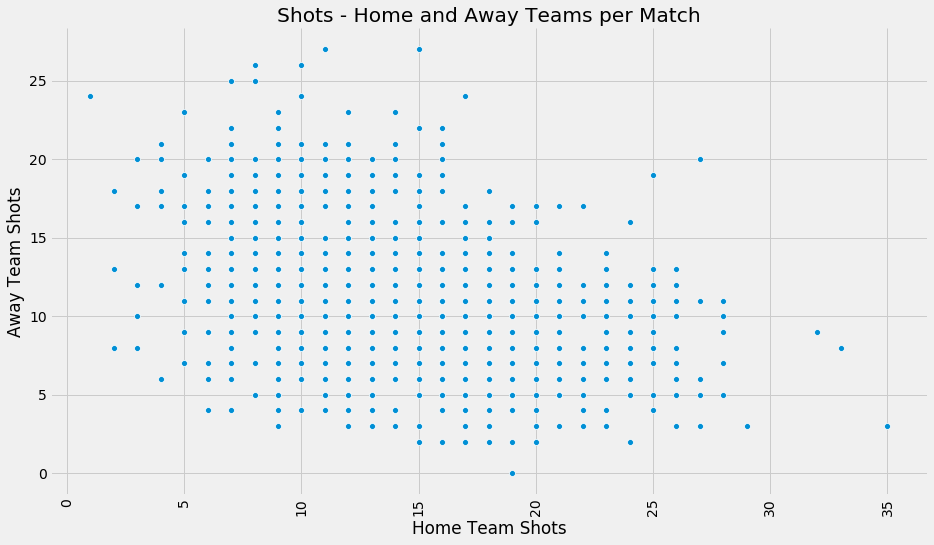

In [12]:
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(ncols=1, nrows=1,figsize=(14,8))

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
#sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x=df['h_shots'], y=df['a_shots'],
               # size = df['a'], sizes=(5,500),

                data=df, ax=ax1)

ax1.set_title('Shots - Home and Away Teams per Match')
ax1.set_ylabel('Away Team Shots')
ax1.set_xlabel("Home Team Shots")
plt.xticks(rotation=90)

#sns.swarmplot(df['h_goals'], df['h_shots'])#'species', 'sepal_length', data=iris)
sns.despine()

plt.show();

In [13]:
# Approxiamte to a Normal Distribution andf Fit QQ Plot
# Approximate to a Negative Binomial and review Rootogram

In [14]:
# https://github.com/gokceneraslan/fit_nbinom/blob/master/fit_nbinom.py
#!/usr/bin/env python

## fit_nbinom
# Copyright (C) 2014 Gokcen Eraslan
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

import numpy as np
from scipy.special import gammaln
from scipy.special import psi, factorial
from scipy.optimize import fmin_l_bfgs_b as optim

#import sys


# X is a numpy array representing the data
# initial params is a numpy array representing the initial values of
# size and prob parameters
def fit_nbinom(X, initial_params=None):
    infinitesimal = np.finfo(np.float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result

    def log_likelihood_deriv(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        pderiv = (N*r)/p - np.sum(X)/(1-(p if p < 1 else 1-infinitesimal))
        rderiv = np.sum(psi(X + r)) \
            - N*psi(r) \
            + N*np.log(p)

        return np.array([-rderiv, -pderiv])

    if initial_params is None:
        #reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m**2)/(v-m) if v > m else 10

        #convert mu/size parameterization to prob/size
        p0 = size / ((size+m) if size+m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     #fprime=log_likelihood_deriv,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'size': params[0], 'prob': params[1]}

In [15]:
# Fit the negative binomial to estimate the parameters
param_dict = fit_nbinom(df['h_shots'])
print(param_dict)

{'size': 15.580280427598934, 'prob': 0.5263212833497435}


In [16]:
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
mean, var, skew, kurt = stats.nbinom.stats(param_dict['size'], param_dict['prob'], moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_shots_mean:\t{h_shots_mean}\th_shots_var:\t{h_shots_var}')

mean:		14.021943386036488	variance:	26.641414340675308
h_shots_mean:	14.021929824561404	h_shots_var:	26.511371162762092


In [17]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(shots_dists.index, param_dict['size'], param_dict['prob'])

exp = norm_exp * shots_dists['h_shots'].sum()
h_shots_nbinom = pd.DataFrame(np.vstack([shots_dists['h_shots'].values, exp, norm_exp])).T
h_shots_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_shots_nbinom['obs_norm'] = h_shots_nbinom['obs']/ h_shots_nbinom['obs'].sum()
h_shots_nbinom

,obs,exp,exp_norm,obs_norm
0,0.0,0.051751,0.000045,0.000000
1,1.0,0.381923,0.000335,0.000877
2,3.0,1.499758,0.001316,0.002632
3,5.0,4.163030,0.003652,0.004386
4,10.0,9.159793,0.008035,0.008772
5,11.0,16.990980,0.014904,0.009649
6,27.0,27.605927,0.024216,0.023684
7,45.0,40.313013,0.035362,0.039474
8,51.0,53.897481,0.047278,0.044737
9,58.0,66.889631,0.058675,0.050877


In [18]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_shots_nbinom['obs'],
                              f_exp=h_shots_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=28.269701295527238, pvalue=0.744135104987552)



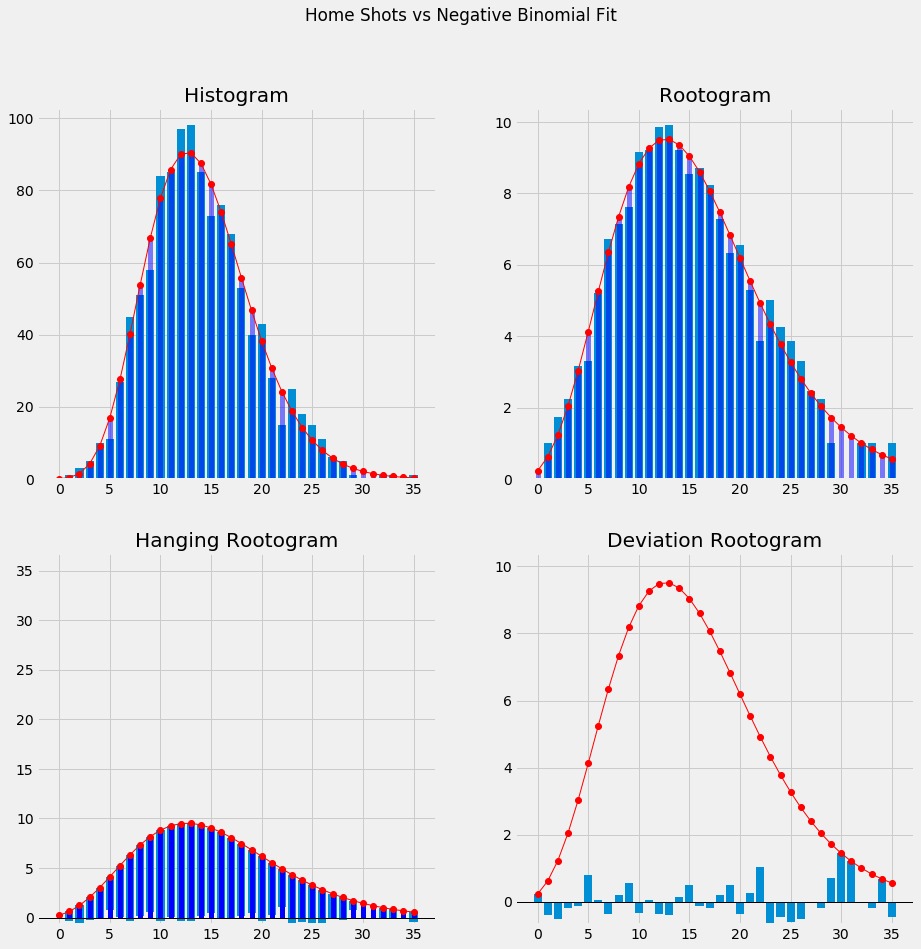

In [19]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_shots_nbinom.index,
                                  h_shots_nbinom['obs'],
                                  h_shots_nbinom['exp'])
plt.suptitle('Home Shots vs Negative Binomial Fit')

plt.show();